### data and package imports

In [1]:
import os
from datetime import datetime
import imageio
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib import transforms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from jenkspy import JenksNaturalBreaks
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from tqdm.notebook import tqdm

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])

# population estimate for 2020
pop_df = pd.read_excel(
    "./data/PopulationEstimates.xlsx",
    sheet_name="Population",
    skiprows=[0,1,2,3]
)

# geometry shape file - county level
cgdf = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")

# geometry shape file - state level
sgdf = gpd.read_file("./data/cb_2022_us_state_500k/cb_2022_us_state_500k.shp")
sgdf = sgdf.drop(['ALAND', 'AWATER','GEOID', 'AFFGEOID', 'STATENS'], axis=1)

# opioid overdose death
death_df = pd.read_csv("./data/Multiple Cause of Death, 2018-2021, Single Race (2).txt", sep="\t")
death_df = death_df.drop(columns="Notes").dropna()

In [3]:
# Opioid dispensing rate 2006-2020
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False

if REFRESH_OPIOID_SOURCE:
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(
            f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html"
        )[0]
        df["year"] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [
    pd.read_csv(f"./data/opioid_rx/{file}")
    for file in os.listdir("./data/opioid_rx")
    if file[-3:] == "csv"
]
df = pd.concat(l)

df["year"] = df["year"].fillna(2020)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df["County FIPS Code"] = np.where(
    (df["year"] == 2020), df["State_County FIPS Code"], df["County FIPS Code"]
)

df = df.reset_index().drop(
    ["Unnamed: 0", "index", "State_County FIPS Code", "State FIPS code"], axis=1
)

df['Opioid Dispensing Rate per 100'] = df['Opioid Dispensing Rate per 100'].apply(lambda x: round(x, 2))
df.sample(5)

df.info()

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
7940,"Moore, NC",NC,37125.0,114.7,2009.0
27617,MILWAUKEE,WI,55079.0,63.8,2017.0
23574,"Lincoln, NM",NM,35027.0,92.6,2016.0
1858,"Keya Paha, NE",NE,31103.0,NaN,2008.0
15467,"Hempstead, AR",AR,5057.0,119.6,2015.0


In [5]:
(
    df.loc[df.groupby('year')['Opioid Dispensing Rate per 100']
    .idxmax()]
)

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
36936,"Martinsville, VA",VA,51690.0,403.3,2006.0
33793,"Martinsville, VA",VA,51690.0,438.4,2007.0
2923,"Martinsville, VA",VA,51690.0,474.7,2008.0
9147,"Martinsville, VA",VA,51690.0,520.1,2009.0
43222,"Martinsville, VA",VA,51690.0,566.4,2010.0
46365,"Martinsville, VA",VA,51690.0,583.8,2011.0
40082,"Norton, VA",VA,51720.0,570.1,2012.0
30653,"Norton, VA",VA,51720.0,578.1,2013.0
21412,"Norton, VA",VA,51720.0,563.3,2014.0
18269,"Norton, VA",VA,51720.0,504.9,2015.0


In [7]:
dd = death_df.copy()
dd['Crude Rate'] = death_df['Crude Rate'].replace('Unreliable', np.nan)
dd.isna().sum().sum() / (dd.shape[0] * dd.shape[1])

0.07174975562072336

In [73]:
(
    df.query('year==2020')
    .merge(pop_df[['FIPStxt', 'CENSUS_2020_POP']], 
             how='inner',
             right_on='FIPStxt',
             left_on='County FIPS Code')
    .assign(census_base100 = lambda x: x['CENSUS_2020_POP'] / 100)
    .assign(prescriptions = lambda x: round(x['Opioid Dispensing Rate per 100'] * x['census_base100']))
    .sort_values('prescriptions', ascending=False)
    # .query('County == \'NORTON CITY\'')
)

,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year,FIPStxt,CENSUS_2020_POP,census_base100,prescriptions
202,LOS ANGELES,CA,6037.0,24.5,2020.0,6037,10014009.0,100140.09,2453432.0
599,COOK,IL,17031.0,36.1,2020.0,17031,5275541.0,52755.41,1904470.0
101,MARICOPA,AZ,4013.0,42.4,2020.0,4013,4420568.0,44205.68,1874321.0
2577,HARRIS,TX,48201.0,37.8,2020.0,48201,4731145.0,47311.45,1788373.0
2535,DALLAS,TX,48113.0,45.9,2020.0,48113,2613539.0,26135.39,1199614.0
...,...,...,...,...,...,...,...,...,...
1986,OLIVER,ND,38065.0,0.1,2020.0,38065,1877.0,18.77,2.0
1870,CAMDEN,NC,37029.0,0.0,2020.0,37029,10355.0,103.55,0.0
296,SAGUACHE,CO,8109.0,0.0,2020.0,8109,6368.0,63.68,0.0
531,WHEELER,GA,13309.0,0.0,2020.0,13309,7471.0,74.71,0.0


In [8]:
(
    df.query("year == 2020")
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .head(5)
)

,State,Opioid Dispensing Rate per 100
0,AL,56.913433
1,AR,56.773333
2,TN,53.225263
3,KY,52.556303
4,GA,45.888462


In [9]:
(
    df.query("year == 2020")
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .assign(
        perc_national=lambda x: (
            x["Opioid Dispensing Rate per 100"]
            / sum(x["Opioid Dispensing Rate per 100"])
        )
        * 100
    )
)

,State,Opioid Dispensing Rate per 100,perc_national
0,GA,7158.6,5.992817
1,KY,6254.2,5.235699
2,TX,6179.6,5.173248
3,VA,5923.7,4.959022
4,TN,5056.4,4.232962
5,KS,4722.9,3.953773
6,NC,4345.0,3.637414
7,AR,4258.0,3.564582
8,MO,4192.7,3.509916
9,IL,3993.6,3.343240


State
AL    AxesSubplot(0.125,0.11;0.775x0.77)
AR    AxesSubplot(0.125,0.11;0.775x0.77)
KY    AxesSubplot(0.125,0.11;0.775x0.77)
TN    AxesSubplot(0.125,0.11;0.775x0.77)
WV    AxesSubplot(0.125,0.11;0.775x0.77)
Name: Opioid Dispensing Rate per 100, dtype: object

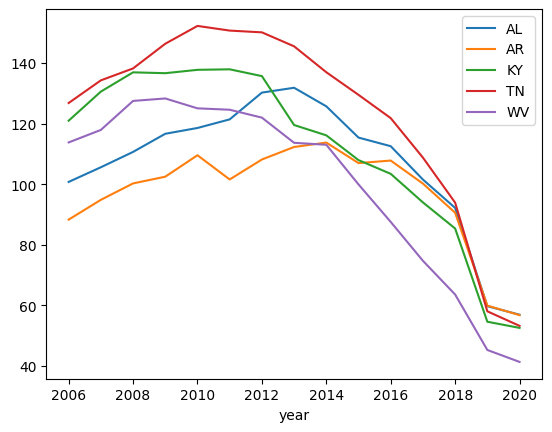

In [10]:
(
    df.groupby(["State", "year"])["Opioid Dispensing Rate per 100"]
    .mean()
    .reset_index()
    .merge(
        df.groupby(["State"])["Opioid Dispensing Rate per 100"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
        .head(5)["State"],
        how="inner",
        on="State",
    )
    .set_index("year")
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .plot(kind="line", subplots=False, legend=True)
)

In [91]:
(
    df.isna()
    .sum()
    .reset_index()
    .merge(df.count().reset_index(), how="inner", on="index")
    .assign(missing_perc=lambda x: (x["0_x"] / x["0_y"]) * 100)
    .rename(columns={"0_x": "missing data",
                     '0_y': "total data count"})
)

,index,missing data,total data count,missing_perc
0,County,0,46585,0.000000
1,State,0,46585,0.000000
2,County FIPS Code,0,46585,0.000000
3,Opioid Dispensing Rate per 100,3705,42880,8.640392
4,year,0,46585,0.000000


In [86]:
df.count().reset_index()

,index,0
0,County,46585
1,State,46585
2,County FIPS Code,46585
3,Opioid Dispensing Rate per 100,42880
4,year,46585


In [11]:
df.groupby(['State'])['Opioid Dispensing Rate per 100'].mean().sort_values(ascending=False).reset_index().head(5)

,State,Opioid Dispensing Rate per 100
0,TN,122.836584
1,KY,110.825158
2,AL,106.574197
3,WV,99.817618
4,AR,96.645557


### Exploratory data analysis - opioid dispensing rate

In [ ]:
(
    df[["Opioid Dispensing Rate per 100", "year"]].plot.hist(
        by="year",
        figsize=(14, 10),
        layout=(7, 2),
        sharex=True,
        sharey=True,
        legend=False,
        bins=30,
    )
)

plt.tight_layout()

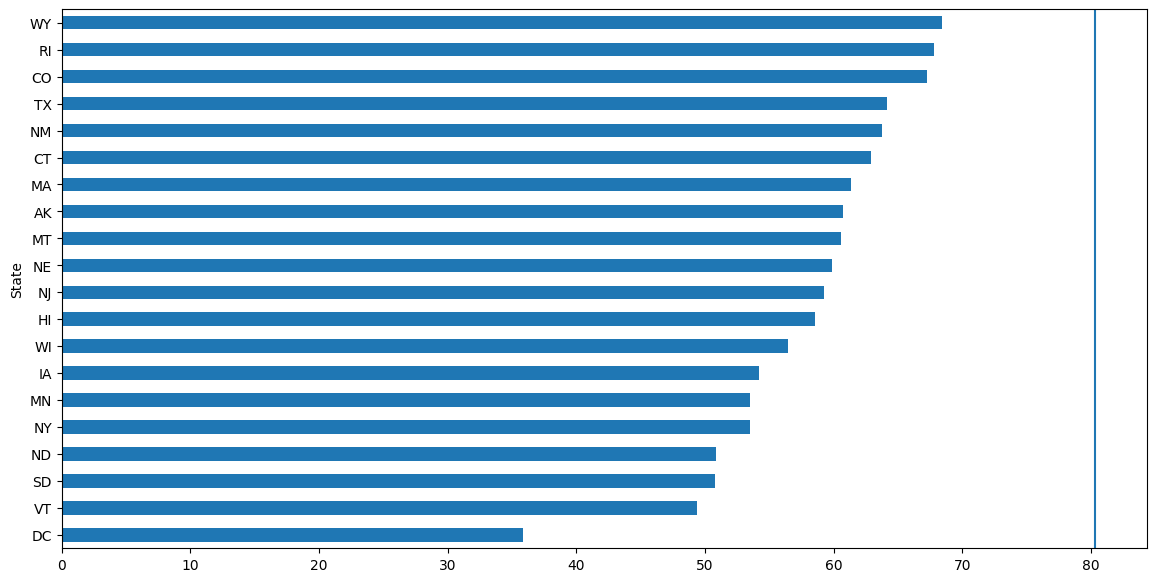

In [ ]:
plt.figure(figsize=(14, 7))

(
    df
    .groupby("State")["Opioid Dispensing Rate per 100"]
    .mean()
    .sort_values()
    .head(20)
    .plot.barh()
)

plt.axvline(x=df['Opioid Dispensing Rate per 100'].mean())

Text(0.5, 1.0, 'Opioid dispensing rate per 100 (2006-2019)')

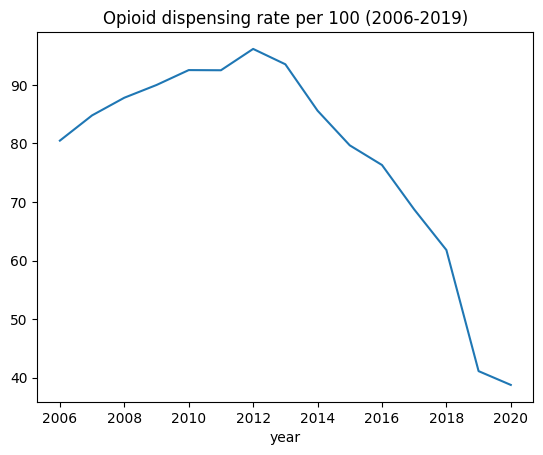

In [13]:
(
    df
    .groupby("year")["Opioid Dispensing Rate per 100"]
    .mean()
    .plot.line()
)

plt.title("Opioid dispensing rate per 100 (2006-2019)")

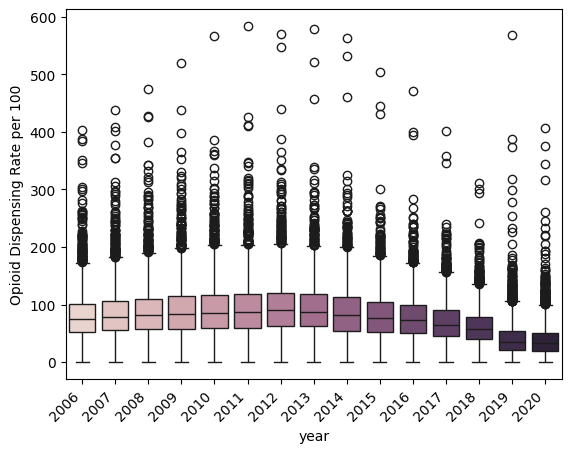

In [14]:
ax = sns.boxplot(data = df, x = "year", y = "Opioid Dispensing Rate per 100", hue = "year")
ax.get_legend().remove()
plt.xticks(rotation=45, horizontalalignment="right")
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label))) for label in labels]);

In [15]:
trydf = df.copy()
trydf = trydf.rename(columns={"County FIPS Code": "GEOID"})
trydf['GEOID'] = trydf['GEOID'].astype("float")
cgdf['GEOID'] = cgdf['GEOID'].astype("float")
# cgdf["GEOID"] = cgdf["GEOID"].str.lstrip("0")
trydf["year"] = trydf["year"].astype("int")

In [16]:
gdf = cgdf.merge(trydf, how="left", on="GEOID").drop(
    columns=[
        "STATEFP",
        "COUNTYFP",
        "COUNTYNS",
        "AFFGEOID",
        "LSAD",
        "ALAND",
        "AWATER",
    ]
)

##### Viz|

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = gdf["Opioid Dispensing Rate per 100"].min()
vmax = gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in tqdm(range(2006, 2021)):
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    gdf[~(gdf["State"].isin(["AK", "HI"])) & (gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    gdf[(gdf["State"] == "AK") & (gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    gdf[(gdf["State"] == "HI") & (gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        gdf[gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=30
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

In [ ]:
fname = "./visualization/2006-2020 county continuous opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in tqdm(sorted([f for f in os.listdir(os.curdir + "/viz_raw") if os.path.isfile(os.curdir + "/viz_raw/" + f)])):
        image = imageio.imread("./viz_raw/" + filename)
        writer.append_data(image)

  0%|          | 0/15 [00:00<?, ?it/s]

### Exploratory data analysis - unemployment rate

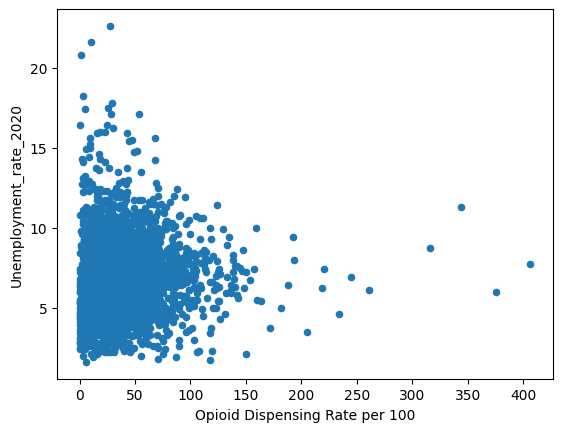

In [423]:
y = 2020

df_sub = df.query(f"year == {y}")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].astype("int").astype("str")
df_sub['County FIPS Code'] = df_sub['County FIPS Code'].str.pad(5, side = "left", fillchar='0')

unemp_dispense = (
    df_sub.merge(
        unemp_df.loc[:, unemp_df.columns.str.contains(f"FIPS|Unemployment_rate_{y}")],
        how="left",
        right_on = "FIPS_Code",
        left_on = "County FIPS Code"
    )
)

unemp_dispense.plot(x = "Opioid Dispensing Rate per 100", y = f"Unemployment_rate_{y}", kind = 'scatter');

In [424]:
unemp_dispense[f'Unemployment_rate_{y}'] = unemp_dispense[f'Unemployment_rate_{y}'].astype("float")
s = smf.ols(formula = f"Q('Opioid Dispensing Rate per 100') ~ Q('Unemployment_rate_{y}')", data=unemp_dispense).fit()
s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Q('Opioid Dispensing Rate per 100')   R-squared:                       0.003
Model:                                             OLS   Adj. R-squared:                  0.003
Method:                                  Least Squares   F-statistic:                     10.20
Date:                                 Tue, 31 Oct 2023   Prob (F-statistic):            0.00142
Time:                                         10:42:26   Log-Likelihood:                -14938.
No. Observations:                                 3081   AIC:                         2.988e+04
Df Residuals:                                     3079   BIC:                         2.989e+04
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      33.5290      1.733     19.346      0.000      30.131      36.927
Q('Unemployment_rate_2020')     0.7704      0.241      3.193      0.001       0.297       1.243
==============================================================================
Omnibus:                     2116.103   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55004.842
Skew:                           2.898   Prob(JB):                         0.00
Kurtosis:                      22.871   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [409]:
# counties with highest dispensing rate
mi = df.groupby('year')['Opioid Dispensing Rate per 100'].idxmax() 

df.reset_index().loc[mi]

,index,County,State,County FIPS Code,Opioid Dispensing Rate per 100,year
36936,36936,"Martinsville, VA",VA,51690.0,403.299988,2006.0
33793,33793,"Martinsville, VA",VA,51690.0,438.399994,2007.0
2923,2923,"Martinsville, VA",VA,51690.0,474.700012,2008.0
9147,9147,"Martinsville, VA",VA,51690.0,520.099976,2009.0
43222,43222,"Martinsville, VA",VA,51690.0,566.400024,2010.0
46365,46365,"Martinsville, VA",VA,51690.0,583.799988,2011.0
40082,40082,"Norton, VA",VA,51720.0,570.099976,2012.0
30653,30653,"Norton, VA",VA,51720.0,578.099976,2013.0
21412,21412,"Norton, VA",VA,51720.0,563.299988,2014.0
18269,18269,"Norton, VA",VA,51720.0,504.899994,2015.0


### State level dispensing rate

In [18]:
state_rx = df.groupby(['State', 'year'], as_index=False).agg({"Opioid Dispensing Rate per 100": "mean"})

jnb = JenksNaturalBreaks(5)
jnb.fit(state_rx['Opioid Dispensing Rate per 100'])

cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

state_rx['cls'] = state_rx['Opioid Dispensing Rate per 100'].apply(lambda x: "abcde"[jnb.predict(x)])

In [19]:
state_rx.loc[state_rx.groupby(['year'])['Opioid Dispensing Rate per 100'].idxmax()]

,State,year,Opioid Dispensing Rate per 100,cls
630,TN,2006.0,126.802174,e
631,TN,2007.0,134.281319,e
632,TN,2008.0,138.218280,e
633,TN,2009.0,146.366667,e
634,TN,2010.0,152.250538,e
635,TN,2011.0,150.708602,e
636,TN,2012.0,150.129032,e
637,TN,2013.0,145.515217,e
638,TN,2014.0,136.963158,e
639,TN,2015.0,129.495789,e


In [20]:
strx_gdf = sgdf[['STUSPS', 'geometry']].merge(state_rx, how="right", left_on="STUSPS", right_on="State")
strx_gdf.head(5)

,STUSPS,geometry,State,year,Opioid Dispensing Rate per 100,cls
0,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2006.0,84.533333,c
1,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2007.0,80.070000,c
2,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2008.0,82.590000,c
3,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2009.0,82.650000,c
4,AK,"MULTIPOLYGON (((-152.85279 70.89539, -152.8498...",AK,2010.0,84.270000,c


In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    
    strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(
        epsg=2163
    ).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        legend=True,
        ax=ax,
        legend_kwds={"label": "Opioid Dispensing Rate per 100", "shrink": 0.7},
        edgecolor="k",
        vmin=vmin,
        vmax=vmax
    )
    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(epsg=3338).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_ak,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.43, 0.05, 0.2, 0.3])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(epsg=4326).fillna(1e-6).plot(
        column="Opioid Dispensing Rate per 100",
        cmap=matplotlib.cm.Reds,
        ax=ax_hi,
        vmin=vmin,
        vmax=vmax,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"].mean().reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(vmin, vmax)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state continuous opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/state/") if os.path.isfile(os.curdir + "/viz_raw/state/" + f)]):
        image = imageio.imread("./viz_raw/state/" + filename)
        writer.append_data(image)

In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = strx_gdf["Opioid Dispensing Rate per 100"].min()
vmax = strx_gdf["Opioid Dispensing Rate per 100"].max()

colmap = plt.cm.Reds

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])]
color_dict = {i:c for i,c in zip("abcde", plot_color)}

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = filtered_data = strx_gdf[~(strx_gdf["State"].isin(["AK", "HI"])) & (strx_gdf["year"] == i)].to_crs(epsg=2163)
    filtered_data.plot(
        # column="Opioid Dispensing Rate per 100",
        # scheme="user_defined",
        # classification_kwds=dict(bins=jnb.breaks_),
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, 'loc':'lower right'},
        edgecolor="k",
    )

    legend_patches = [Patch(color=color_dict[cls], label=cls) for cls in color_dict.keys()]
    ax.legend(handles=legend_patches, frameon=False, loc='lower right', labels=cls)

    ax.grid(False)
    ax.axis("off")
    ax.set_title(
        f"Opioid dispensing rate per 100 persons, {i}", fontdict={"fontsize": 25}
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "AK") & (strx_gdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    strx_gdf[(strx_gdf["State"] == "HI") & (strx_gdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color = filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = (
            strx_gdf.groupby("year")["Opioid Dispensing Rate per 100"]
            .mean()
            .reset_index()
        )
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Opioid Dispensing Rate per 100"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Opioid Dispensing Rate per 100"]].plot(
            x="year", y="Opioid Dispensing Rate per 100", ax=ax_pp
        )
        ax_pp.set_title("Yearly trend of national mean dispensing rate")
        ax_pp.set_ylabel("Dispensing rate per 100 persons")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Opioid Dispensing Rate per 100'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 45),
        )
        ax_pp.set_ylim(0, 90)
        ax_pp.get_legend().remove()

        # histogram of dispensing rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        strx_gdf[strx_gdf["year"] == i]["Opioid Dispensing Rate per 100"].plot(
            kind="hist", ax=ax_hist, bins=15
        )
        ax_hist.set_title(f"Distribution of dispensing rate for {i}")
        ax_hist.set_xlim(0, vmax)
        ax_hist.set_ylim(0, 15)
        ax_hist.set_xlabel("Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/state_jnb/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid dispensing rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/state_jnb/") if os.path.isfile(os.curdir + "/viz_raw/state_jnb/" + f)]):
        image = imageio.imread("./viz_raw/state_jnb/" + filename)
        writer.append_data(image)

### Exploratory data analysis - opioid death rates

In [23]:
death_df = pd.DataFrame()

for file in os.listdir("./data/WONDER"):
    if file[-3:] == "txt":
        temp = pd.read_csv(f"./data/WONDER/{file}", sep="\t")
        temp["year"] = int(file[-8:-4])
        temp.drop("Notes", axis=1, inplace=True)
        death_df = pd.concat([temp, death_df], axis=0)

death_df = (
    death_df.reset_index()
    .dropna(subset=["County", "County Code", "Deaths", "Population", "Crude Rate"])
    .drop("index", axis=1)
)

In [24]:
death_df.isna().sum().sum() / (death_df.shape[0] * death_df.shape[1])

0.0

In [25]:
death_df['State'] = death_df['County'].apply(lambda x: x.split(', ')[1])
death_df['Rate'] = (death_df['Deaths'] / death_df['Population']) * 100000
death_df = death_df.drop(death_df[death_df['Crude Rate'] == "Unreliable"].index)
death_df['Crude Rate'] = death_df['Crude Rate'].astype("float32")

jnb = JenksNaturalBreaks(5)
jnb.fit(death_df['Crude Rate'])

# generate a list of strings for the break ranges
cls = []
for i in range(len(jnb.breaks_)):
     try: 
          a = str(round(jnb.breaks_[i], 1))
          b = str(round(jnb.breaks_[i+1], 1))
          cls.append(f"{a}-{b}")
     except:
          pass

death_df['cls'] = death_df['Crude Rate'].apply(lambda x: "abcde"[jnb.predict(x)])
death_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4913 entries, 1 to 9844
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   County       4913 non-null   object 
 1   County Code  4913 non-null   float64
 2   Deaths       4913 non-null   float64
 3   Population   4913 non-null   float64
 4   Crude Rate   4913 non-null   float32
 5   year         4913 non-null   int64  
 6   State        4913 non-null   object 
 7   Rate         4913 non-null   float64
 8   cls          4913 non-null   object 
dtypes: float32(1), float64(4), int64(1), object(3)
memory usage: 364.6+ KB


In [26]:
# 1. Create a complete list of state-year combinations
all_states = sgdf["STUSPS"].unique()
all_years = death_df["year"].unique()

# Cartesian product of states and years
state_years = pd.MultiIndex.from_product(
    [all_states, all_years], names=["State", "year"]
).to_frame(index=False)

# 2. Merge this list with your data
augmented_death_df = state_years.merge(death_df, on=["State", "year"], how="left")
augmented_death_df['Rate'] = augmented_death_df['Rate'].fillna(1e-3)
augmented_death_df['cls'] = augmented_death_df['cls'].fillna(" ")

death_sgdf = sgdf.merge(
    (augmented_death_df.groupby(["State", "cls", "year"])["Rate"].mean().reset_index()),
    how="left",
    left_on="STUSPS",
    right_on="State",
)

death_sgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1484 non-null   object  
 1   STUSPS    1484 non-null   object  
 2   NAME      1484 non-null   object  
 3   LSAD      1484 non-null   object  
 4   geometry  1484 non-null   geometry
 5   State     1484 non-null   object  
 6   cls       1484 non-null   object  
 7   year      1484 non-null   int64   
 8   Rate      1484 non-null   float64 
dtypes: float64(1), geometry(1), int64(1), object(6)
memory usage: 115.9+ KB


In [27]:
death_sgdf.query("year == 2006 & STUSPS == 'WY'")

,STATEFP,STUSPS,NAME,LSAD,geometry,State,cls,year,Rate
399,56,WY,Wyoming,00,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",WY,,2006,0.001


In [ ]:
# https://stackoverflow.com/questions/67575936/moving-alaska-and-hawaii-in-geopandas-for-choropleths
vmin = death_sgdf["Rate"].min()
vmax = death_sgdf["Rate"].max()

colmap = plt.cm.Reds

death_sgdf = death_sgdf.drop(
    death_sgdf[
        death_sgdf["STUSPS"].isin(
            list(
                set(sgdf["STUSPS"].unique()).difference(set(death_df["State"].unique()))
            )
        )
    ].index
)

plot_color = [mcolors.to_hex(c) for c in colmap([0.2, 0.4, 0.6, 0.8, 1.0])] + [
    "#CCCCCC"
]
color_dict = {i: c for i, c in zip(['a', 'b', 'c', 'd', 'e', ' '], plot_color)}

plot_extra = True
for i in range(2006, 2021):
    print(f"making {i} plot")
    fig, ax = plt.subplots(1, 1, figsize=(11, 9))

    filtered_data = death_sgdf[
        ~(death_sgdf["State"].isin(["AK", "HI"])) & (death_sgdf["year"] == i)
    ].to_crs(epsg=2163)
    filtered_data.plot(
        column="cls",
        categorical=True,
        color=filtered_data["cls"].map(color_dict),
        legend=True,
        ax=ax,
        legend_kwds={"frameon": False, "labels": cls, "loc": "lower right"},
        edgecolor="k",
    )

    legend_patches = [
        Patch(color=color_dict[cls], label=cls) for cls in ['a', 'b', 'c', 'd', 'e']
    ]
    legend_patches.append(Patch(color="#CCCCCC", label="No data"))
    
    ax.legend(handles=legend_patches, frameon=False, loc="lower right", labels=cls + ['No data'])

    ax.grid(False)
    ax.axis("off")
    ax.set_title(f"Opioid Overdose Death Rates, {i}", fontdict={"fontsize": 25})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    pos = ax.get_position()
    bottom_shifted = (
        pos.y0 + -0.15
    )  # This value can be adjusted as per the desired shift
    ax.set_position([pos.x0, bottom_shifted, pos.width, pos.height])

    ax_ak = fig.add_axes([0.1, 0.07, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "AK") & (death_sgdf["year"] == i)].to_crs(
        epsg=3338
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_ak,
        edgecolor="k",
    )
    ax_ak.set_title("Alaska")
    ax_ak.grid(False)
    ax_ak.axis("on")
    ax_ak.set_xticks([])
    ax_ak.set_yticks([])
    # set x, y boundary to ensure consistency across visualization
    ax_ak.set_xbound(-2.25e6, 1.5e6)
    ax_ak.set_ybound(0.37e6, 2.40e6)
    ax_ak.set_xticklabels([])
    ax_ak.set_yticklabels([])

    ax_hi = fig.add_axes([0.59, 0.05, 0.2, 0.2])
    death_sgdf[(death_sgdf["State"] == "HI") & (death_sgdf["year"] == i)].to_crs(
        epsg=4326
    ).fillna(1e-6).plot(
        column="cls",
        categorical=True,
        # cmap=colors.ListedColormap(list(color_dict.values())),
        color=filtered_data["cls"].map(color_dict),
        ax=ax_hi,
        edgecolor="k",
    )
    ax_hi.set_title("Hawaii")
    ax_hi.grid(False)
    ax_hi.axis("on")
    ax_hi.set_xticks([])
    ax_hi.set_yticks([])
    ax_hi.set_xticklabels([])
    ax_hi.set_yticklabels([])

    if plot_extra:
        #
        ax_pp = fig.add_axes([1, 0.58, 0.3, 0.27])
        mean_df = death_sgdf.groupby("year")["Rate"].mean().reset_index()
        ax_pp.plot_date(
            pd.to_datetime(i, format="%Y"),
            [mean_df.loc[i - 2006]["Rate"]],
            "go",
        )
        mean_df["year"] = pd.to_datetime(mean_df["year"], format="%Y")
        mean_df[["year", "Rate"]].plot(x="year", y="Rate", ax=ax_pp)
        ax_pp.set_title("Yearly trend of\nnational mean opioid overdose death rate")
        ax_pp.set_ylabel("Crude death rate")
        ax_pp.annotate(
            f"{i} Mean: {str(round(mean_df.loc[i-2006]['Rate'], 1))}",
            xy=(pd.to_datetime(2007, format="%Y"), 25),
        )
        ax_pp.set_ylim(0, 30)
        ax_pp.get_legend().remove()

        # histogram of death rate of year
        ax_hist = fig.add_axes([1, 0.2, 0.3, 0.27])
        death_sgdf[death_sgdf["year"] == i].groupby('State')["Rate"].mean().plot(
            kind="hist", ax=ax_hist, bins=10
        )
        ax_hist.set_xlim(0, 159.6)
        ax_hist.set_ylim(0, 25)
        ax_hist.set_title(f"Distribution of death rate for {i}")
        ax_hist.set_xlabel("Rate")

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"./viz_raw/ood_jnp/{i}.png", dpi=512, bbox_inches="tight", pad_inches=0.15)
    plt.close()

fname = "./visualization/2006-2020 state opioid od rate.gif"

with imageio.get_writer(fname, mode='I', duration=1000) as writer:
    for filename in sorted([f for f in os.listdir(os.curdir + "/viz_raw/ood_jnp/") if os.path.isfile(os.curdir + "/viz_raw/ood_jnp/" + f)]):
        image = imageio.imread("./viz_raw/ood_jnp/" + filename)
        writer.append_data(image)

<AxesSubplot: xlabel='Opioid Dispensing Rate per 100', ylabel='Crude Rate'>

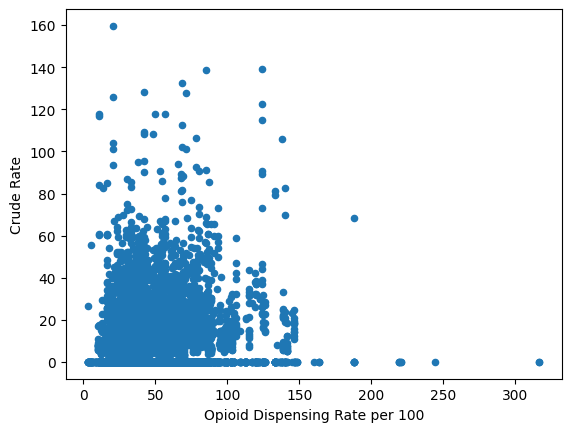

In [169]:
disp_death = death_df.merge(df.query('year==2020'), how="inner", left_on = "County Code", right_on = "County FIPS Code")
county_disp_death = disp_death.groupby('State_x')[['Opioid Dispensing Rate per 100', 'Rate']].mean().reset_index()
disp_death.plot(kind = "scatter",
                x = "Opioid Dispensing Rate per 100",
                y = "Crude Rate")

In [131]:
sgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STUSPS    56 non-null     object  
 2   NAME      56 non-null     object  
 3   LSAD      56 non-null     object  
 4   geometry  56 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 2.3+ KB


In [173]:
pov_df['FIPS_Code'] = pov_df['FIPS_Code'].astype("float32")

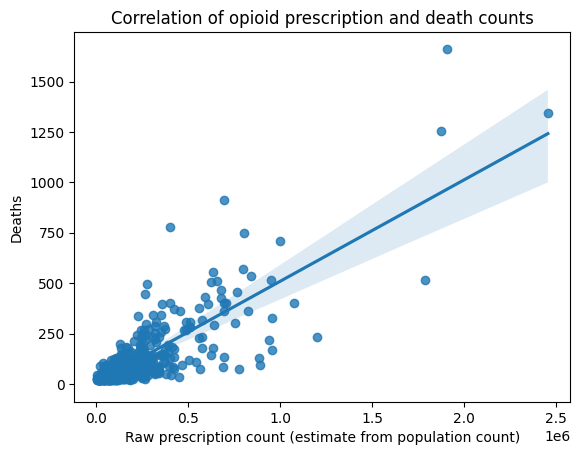

In [373]:
prescription_death = (
    df.query("year==2020")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .assign(census_base100=lambda x: x["CENSUS_2020_POP"] / 100)
    .assign(
        prescriptions=lambda x: round(
            x["Opioid Dispensing Rate per 100"] * x["census_base100"]
        )
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate', "Rate"]].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

prescription_death
ax = sns.regplot(data=prescription_death, x="prescriptions", y="Deaths")
ax.set_title("Correlation of opioid prescription and death counts")
ax.set_xlabel("Raw prescription count (estimate from population count)")
ax.set_ylabel("Deaths")
plt.savefig("./visualization/Opioid prescription and death counts.png", dpi=512)

In [312]:
prescription_death_2006 = (
    df.query("year==2006")
    .merge(
        pop_df[["FIPStxt", "CENSUS_2020_POP"]],
        how="inner",
        right_on="FIPStxt",
        left_on="County FIPS Code",
    )
    .assign(census_base100=lambda x: x["CENSUS_2020_POP"] / 100)
    .assign(
        prescriptions=lambda x: round(
            x["Opioid Dispensing Rate per 100"] * x["census_base100"]
        )
    )
    .merge(
        death_df[["State", "year", "County Code", "Deaths", 'Crude Rate', "Rate"]].query(
            "year == 2020"
        ),
        how="inner",
        left_on="County FIPS Code",
        right_on="County Code",
    )
    # AMFAR_MEDSAFAC_RATE: Total number of substance abuse services facilities accepting Medicaid per 1,000 population
    # AMFAR_MEDMHFAC_RATE: Total number of facilities that provide mental health services and accept Medicaid per 1,000 population
    # ACS_GINI_INDEX: Gini index of income inequality
    .merge(
        sdoh_df[
            [
                "COUNTYFIPS",
                "AHRF_USDA_RUCC_2013",
                "AMFAR_MEDSAFAC_RATE",
                "AMFAR_MEDMHFAC_RATE",
                "SAIPE_MEDIAN_HH_INCOME",
                "ACS_GINI_INDEX",
                "SAIPE_PCT_POV",
            ]
        ],
        how="inner",
        left_on="County FIPS Code",
        right_on="COUNTYFIPS",
    )
    # .merge(pov_df[['FIPS_Code', 'POVALL_2021']], how = "inner", left_on = "County FIPS Code", right_on = 'FIPS_Code')
    .assign(
        ru_continuum=lambda x: np.where(x["AHRF_USDA_RUCC_2013"] >= 4, "Rural", "Urban")
    )
)

reg = prescription_death_2006[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})

smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     115.3
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.11e-24
Time:                        02:12:49   Log-Likelihood:                -782.94
No. Observations:                 589   AIC:                             1570.
Df Residuals:                     587   BIC:                             1579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -1.139e-17      0.038  -3.02e-16      1.000      -0.074       0.074
Q('Opioid Dispensing Rate per 100')     0.4052      0.038     10.738      0.000       0.331       0.479
==============================================================================
Omnibus:                      258.594   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1576.077
Skew:                           1.853   Prob(JB):                         0.00
Kurtosis:                      10.105   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.07, 0.5, 'Crude Death Rate')

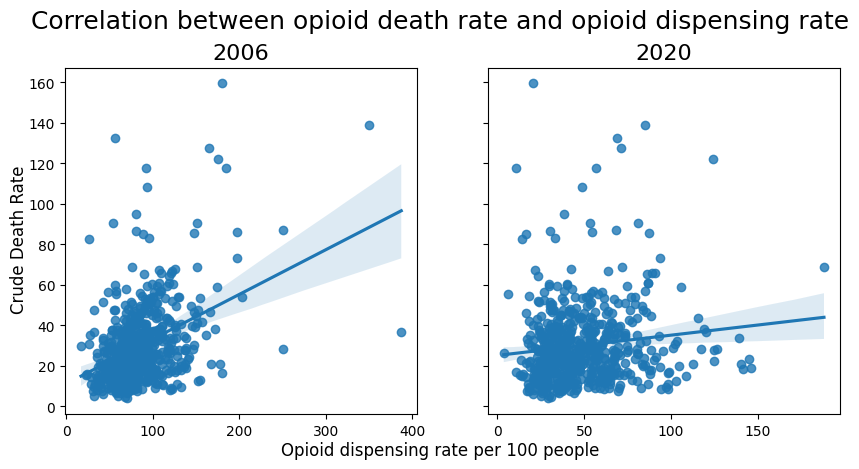

In [366]:
fig, ax = plt.subplots(1, 2, sharey = True, figsize=(10, 4.5))
# plt.tight_layout()


sns.regplot(data=prescription_death_2006, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[0])
sns.regplot(data=prescription_death, x="Opioid Dispensing Rate per 100", y="Crude Rate", ax=ax[1])
# ax.set_title("Correlation between opioid prescription rate\nand opioid overdose death rate (2006)")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("2006", size=16)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("2020", size=16)
fig.suptitle("Correlation between opioid death rate and opioid dispensing rate", size=18, y=1.01)
fig.supxlabel("Opioid dispensing rate per 100 people", y = 0.01)
fig.supylabel("Crude Death Rate", x = 0.07)

In [246]:
(
    unemp_df.loc[:, unemp_df.columns.str.contains("FIPS|State|Area_Name|.*_2020")]
    # .info()
    .astype(
        {
            "FIPS_Code": "int",
            "Civilian_labor_force_2020": "float32",
            "Employed_2020": "float32",
            "Unemployed_2020": "float32",
            "Unemployment_rate_2020": "float32",
            "Med_HH_Income_Percent_of_State_Total_2021": "float32",
        }
    )
    .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 8 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   FIPS_Code                                  3277 non-null   int64  
 1   State                                      3277 non-null   object 
 2   Area_Name                                  3277 non-null   object 
 3   Civilian_labor_force_2020                  3194 non-null   float32
 4   Employed_2020                              3194 non-null   float32
 5   Unemployed_2020                            3194 non-null   float32
 6   Unemployment_rate_2020                     3194 non-null   float32
 7   Med_HH_Income_Percent_of_State_Total_2021  3193 non-null   float32
dtypes: float32(5), int64(1), object(2)
memory usage: 140.9+ KB


In [258]:
unemp_no_state = unemp_df.drop(unemp_df[~unemp_df['Area_Name'].str.contains(",")].index).shape
(unemp_df.drop(unemp_df[~unemp_df['Area_Name'].str.contains(",")].index).isna().sum().sum() / (unemp_no_state[0] * unemp_no_state[1])) * 100

0.33198883028234566

In [269]:
pov_no_state = pov_df[np.where(pov_df['FIPS_Code'] % 1000 == 0, False, True)].shape
(pov_df[np.where(pov_df['FIPS_Code'] % 1000 == 0, False, True)].isna().sum().sum() / (pov_no_state[0] * pov_no_state[1])) * 100

17.683554490838652

In [191]:
prescription_death = prescription_death.drop(['State_x', 'COUNTYFIPS', 'FIPStxt', 'FIPS_Code'], axis=1)

In [193]:
prescription_death['POVALL_2021'] = prescription_death['POVALL_2021'].astype('float32')

In [374]:
sdoh_reg = prescription_death[['Crude Rate', 'AMFAR_MEDSAFAC_RATE', 'AMFAR_MEDMHFAC_RATE', 'SAIPE_MEDIAN_HH_INCOME', 'ACS_GINI_INDEX', 'SAIPE_PCT_POV', 'prescriptions']]
pipe = ColumnTransformer((
    ('ss', StandardScaler(), sdoh_reg.columns),
))

sdoh_reg = pd.DataFrame(pipe.fit_transform(sdoh_reg), columns=pipe.named_transformers_.ss.get_feature_names_out())
sdoh_reg = pd.concat([sdoh_reg, prescription_death['ru_continuum']], axis=1)

In [376]:
smf.ols(formula="Q('prescriptions') ~ + Q('AMFAR_MEDSAFAC_RATE') + Q('AMFAR_MEDMHFAC_RATE') + Q('SAIPE_MEDIAN_HH_INCOME') + Q('ACS_GINI_INDEX') + Q('SAIPE_PCT_POV') + C(ru_continuum)", data = sdoh_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Q('prescriptions')   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     27.62
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           4.64e-29
Time:                        17:51:18   Log-Likelihood:                -761.96
No. Observations:                 589   AIC:                             1538.
Df Residuals:                     582   BIC:                             1569.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.3996      0.119     -3.352      0.001      -0.634      -0.165
C(ru_continuum)[T.Urban]        0.4475      0.127      3.521      0.000       0.198       0.697
Q('AMFAR_MEDSAFAC_RATE')       -0.0832      0.047     -1.767      0.078      -0.176       0.009
Q('AMFAR_MEDMHFAC_RATE')       -0.0779      0.047     -1.667      0.096      -0.170       0.014
Q('SAIPE_MEDIAN_HH_INCOME')     0.1052      0.062      1.691      0.091      -0.017       0.227
Q('ACS_GINI_INDEX')             0.4116      0.044      9.272      0.000       0.324       0.499
Q('SAIPE_PCT_POV')              0.0087      0.069      0.126      0.900      -0.127       0.144
==============================================================================
Omnibus:                      545.145   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20434.028
Skew:                           4.030   Prob(JB):                         0.00
Kurtosis:                      30.707   Cond. No.                         7.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [377]:
smf.ols(formula="Q('Crude Rate') ~ + Q('AMFAR_MEDSAFAC_RATE') + Q('AMFAR_MEDMHFAC_RATE') + Q('SAIPE_MEDIAN_HH_INCOME') + Q('ACS_GINI_INDEX') + Q('SAIPE_PCT_POV') + C(ru_continuum)", data = sdoh_reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     34.61
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           8.29e-36
Time:                        17:52:13   Log-Likelihood:                -745.90
No. Observations:                 589   AIC:                             1506.
Df Residuals:                     582   BIC:                             1536.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4137      0.116      3.566      0.000       0.186       0.642
C(ru_continuum)[T.Urban]       -0.4633      0.124     -3.746      0.000      -0.706      -0.220
Q('AMFAR_MEDSAFAC_RATE')        0.1781      0.046      3.885      0.000       0.088       0.268
Q('AMFAR_MEDMHFAC_RATE')        0.0981      0.045      2.157      0.031       0.009       0.187
Q('SAIPE_MEDIAN_HH_INCOME')    -0.0663      0.060     -1.096      0.274      -0.185       0.053
Q('ACS_GINI_INDEX')            -0.0449      0.043     -1.040      0.299      -0.130       0.040
Q('SAIPE_PCT_POV')              0.2708      0.067      4.034      0.000       0.139       0.403
==============================================================================
Omnibus:                      221.469   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.303
Skew:                           1.647   Prob(JB):                    3.39e-221
Kurtosis:                       8.524   Cond. No.                         7.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
sm.stats.anova_oneway(data = prescription_death['Deaths'], groups = prescription_death['ru_continuum'], use_var = 'unequal')

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 150.87218292000287
pvalue = 1.1265284698623519e-31
df = (1.0, 735.0535662163039)
df_num = 1.0
df_denom = 735.0535662163039
nobs_t = 919.0
n_groups = 2
means = array([18.89719626, 84.6212766 ])
nobs = array([214., 705.])
vars_ = array([  135.9142644 , 19737.25551257])
use_var = 'unequal'
welch_correction = True
tuple = (150.87218292000287, 1.1265284698623519e-31)

In [238]:
# Q5 Statistical tests
import scipy.stats as stats

g1 = prescription_death["Deaths"][prescription_death["ru_continuum"] == "Urban"]
g2 = prescription_death["Deaths"][prescription_death["ru_continuum"] == "Rural"]


pd.DataFrame(
    {
        "Shapiro-Wilk's test of normality": stats.shapiro(prescription_death["Deaths"]),
        "Shapiro-Wilk's test of normality (Urban)": stats.shapiro(g1),
        "Shapiro-Wilk's test of normality (Rural)": stats.shapiro(g2),
        "Levene's test of homoscedasticity": stats.levene(g1, g2),
    },
    index=['Test Statistics', 'p-value']
).T

,Test Statistics,p-value
Shapiro-Wilk's test of normality,0.454127,0.000000e+00
Shapiro-Wilk's test of normality (Urban),0.500767,1.921096e-40
Shapiro-Wilk's test of normality (Rural),0.693197,1.567256e-19
Levene's test of homoscedasticity,38.440514,8.524859e-10


In [316]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


reg = prescription_death[['Opioid Dispensing Rate per 100', 'Crude Rate']]
pipe = ColumnTransformer((
    ('prescription', StandardScaler(), reg.columns),
))

reg = pd.DataFrame(pipe.fit_transform(reg)).rename(columns={0: 'Opioid Dispensing Rate per 100', 1:'Crude Rate'})

smf.ols(formula="Q('Crude Rate')~Q('Opioid Dispensing Rate per 100')", data = reg).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Q('Crude Rate')   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     9.165
Date:                Tue, 28 Nov 2023   Prob (F-statistic):            0.00257
Time:                        02:16:10   Log-Likelihood:                -831.19
No. Observations:                 589   AIC:                             1666.
Df Residuals:                     587   BIC:                             1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                           -6.465e-19      0.041  -1.58e-17      1.000      -0.080       0.080
Q('Opioid Dispensing Rate per 100')     0.1240      0.041      3.027      0.003       0.044       0.204
==============================================================================
Omnibus:                      316.427   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2359.217
Skew:                           2.296   Prob(JB):                         0.00
Kurtosis:                      11.663   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

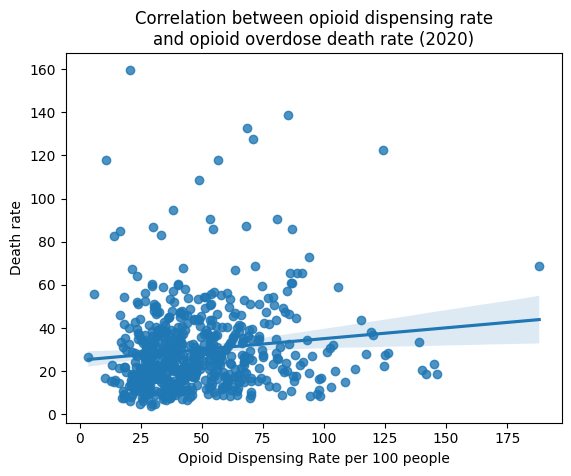

In [317]:
ax = sns.regplot(data = prescription_death, 
            x = "Opioid Dispensing Rate per 100",
            y = "Crude Rate")

ax.set_title("Correlation between opioid dispensing rate\nand opioid overdose death rate (2020)")
ax.set_xlabel("Opioid Dispensing Rate per 100 people")
ax.set_ylabel("Death rate")
plt.savefig("./visualization/dispensing and overdose correlation.png", dpi = 512)

In [281]:
smf.ols(formula="Q('Rate_na_filled')~Q('Opioid Dispensing Rate per 100')", data = prescription_death).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Q('Rate_na_filled')   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.014
Method:                  Least Squares   F-statistic:                     9.165
Date:                 Mon, 27 Nov 2023   Prob (F-statistic):            0.00257
Time:                         17:18:48   Log-Likelihood:                -2586.6
No. Observations:                  589   AIC:                             5177.
Df Residuals:                      587   BIC:                             5186.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              25.0565      1.805     13.880      0.000      21.511      28.602
Q('Opioid Dispensing Rate per 100')     0.1002      0.033      3.027      0.003       0.035       0.165
==============================================================================
Omnibus:                      316.427   Durbin-Watson:                   1.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2359.217
Skew:                           2.296   Prob(JB):                         0.00
Kurtosis:                      11.663   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
smf.ols(formula="Q('Rate')~Q('Opioid Dispensing Rate per 100')", data = disp_death).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Rate')   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     47.97
Date:                Tue, 31 Oct 2023   Prob (F-statistic):           5.81e-12
Time:                        14:15:26   Log-Likelihood:                -8295.0
No. Observations:                2000   AIC:                         1.659e+04
Df Residuals:                    1998   BIC:                         1.661e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              16.0333      0.579     27.683      0.000      14.898      17.169
Q('Opioid Dispensing Rate per 100')     0.0761      0.011      6.926      0.000       0.055       0.098
==============================================================================
Omnibus:                      696.292   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3197.650
Skew:                           1.607   Prob(JB):                         0.00
Kurtosis:                       8.296   Cond. No.                         89.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
smf.ols(formula="Q('Rate')~Q('Opioid Dispensing Rate per 100')", data = county_disp_death).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Q('Rate')   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7357
Date:                Sun, 26 Nov 2023   Prob (F-statistic):              0.395
Time:                        02:53:22   Log-Likelihood:                -203.28
No. Observations:                  51   AIC:                             410.6
Df Residuals:                      49   BIC:                             414.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              30.0075      6.676      4.495      0.000      16.591      43.424
Q('Opioid Dispensing Rate per 100')    -0.1139      0.133     -0.858      0.395      -0.381       0.153
==============================================================================
Omnibus:                       23.016   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.193
Skew:                           1.356   Prob(JB):                     6.89e-10
Kurtosis:                       6.535   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
(
    pd.crosstab(
        index=df["year"],
        columns=df["County FIPS Code"],
        values=df["Opioid Dispensing Rate per 100"],
        aggfunc="count",
    )
    .sum(axis=0)
    .sort_values()
    .reset_index()
    .merge(df[["County FIPS Code", "County"]].drop_duplicates(), how="left", on="County FIPS Code")
    .rename(columns={0:"Reports"})
    .query("Reports == 0")
    .sort_values("County FIPS Code")
)

,County FIPS Code,Reports,County
13,2270.0,0.0,"Wade Hampton, AK"
16,8111.0,0.0,"San Juan, CO"
19,13101.0,0.0,"Echols, GA"
20,13125.0,0.0,"Glascock, GA"
24,15005.0,0.0,"Kalawao, HI"
27,16025.0,0.0,"Camas, ID"
28,16033.0,0.0,"Clark, ID"
8,21201.0,0.0,"Robertson, KY"
15,26083.0,0.0,"Keweenaw, MI"
12,28055.0,0.0,"Issaquena, MS"


In [479]:
import sys
sys.modules[__name__].__dict__.clear()

# References

1. https://stackoverflow.com/questions/55767312/how-to-position-suptitle
2. https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size
3. https://geopandas.org/en/stable/docs/user_guide/missing_empty.html
4. 